<a href="https://colab.research.google.com/github/YooNayoung/ESAA/blob/main/0415.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customers clustering: K-Means, DBSCAN and AP

## 1. Introduction
The main task of clustering is to discover „natural“ groups within an unlabelled dataset - this means that's an unsuprvised ML task. And it's an important one, as as it is used in many scientific, engineering and business domains. One of the most known application of clustering are:

- customers segmentation (for efficient marketing)
- image segmentation
- documents clusterisation.

## 2. Reading data

In [2]:
# importing basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [3]:
mall_data = pd.read_csv('/content/drive/MyDrive/ESAA(OB)/Mall_Customers.csv')
print('There are {} rows and {} columns in our dataset'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset


In [4]:
mall_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
mall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

## 3. Exploratory Data Analysis

### 3.1 Distributions

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


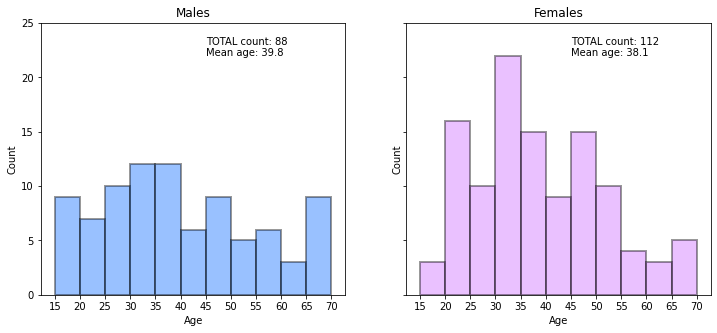

In [9]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

In [10]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


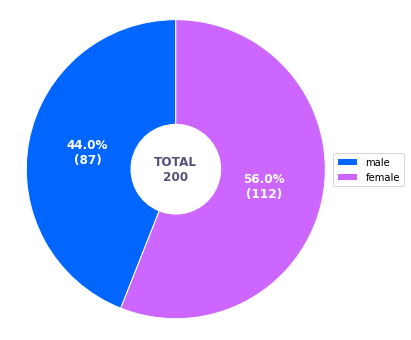

In [11]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


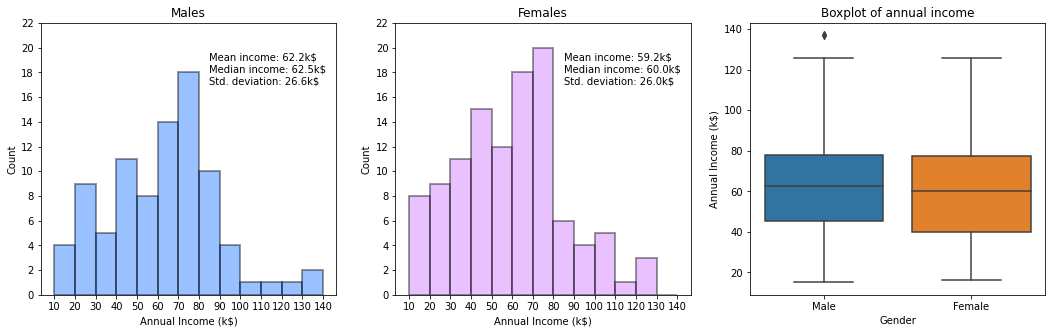

In [12]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

In [13]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


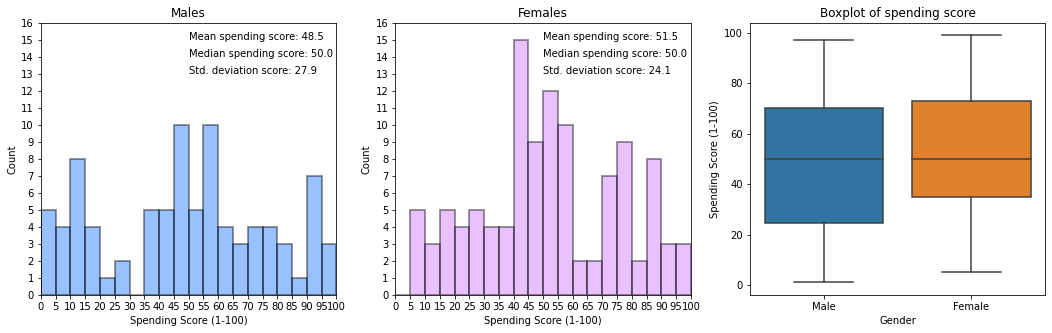

In [14]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

In [15]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


In [16]:
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

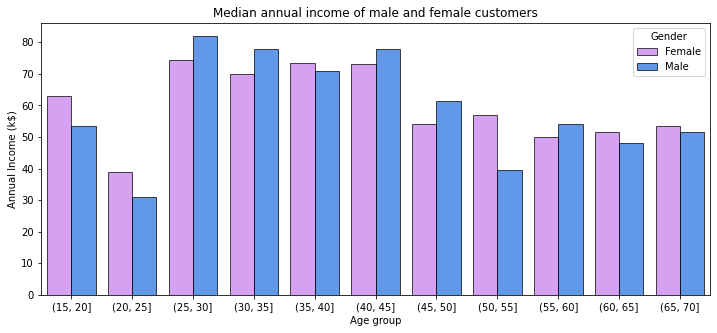

In [17]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

### 3.2 Correlations

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


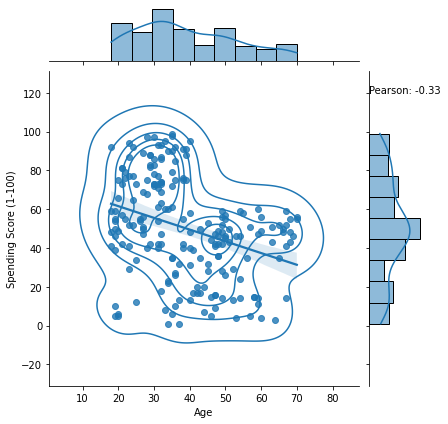

In [18]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

jp = (sns.jointplot('Age', 'Spending Score (1-100)', data=mall_data,
                    kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


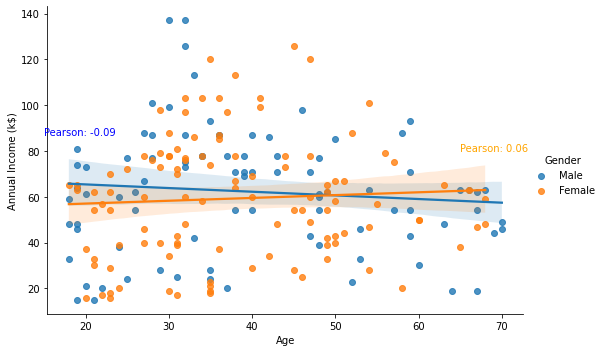

In [19]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot('Age', 'Annual Income (k$)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


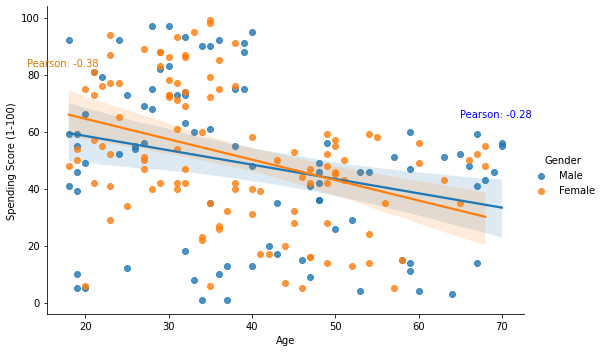

In [20]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot('Age', 'Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


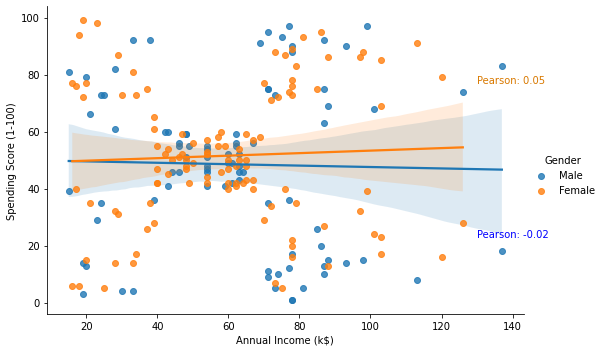

In [22]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot('Annual Income (k$)', 'Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

## 4. Clustering

### 4.1 K-Means

In [23]:
from sklearn.cluster import KMeans 

In [24]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

In [25]:
from sklearn.metrics import silhouette_score
n_clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
clusters_inertia = [] # inertia of clusters
s_scores = [] # silhouette scores

for n in n_clusters:
    KM_est = KMeans(n_clusters=n, init='k-means++').fit(X_numerics)
    clusters_inertia.append(KM_est.inertia_)    # data for the elbow method
    silhouette_avg = silhouette_score(X_numerics, KM_est.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


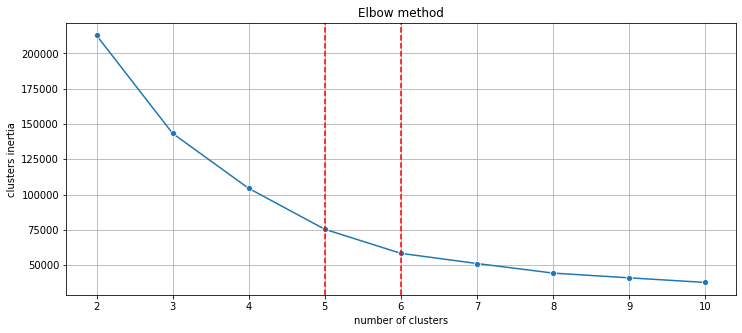

In [26]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, clusters_inertia, marker='o', ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
ax.axvline(5, ls="--", c="red")
ax.axvline(6, ls="--", c="red")
plt.grid()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


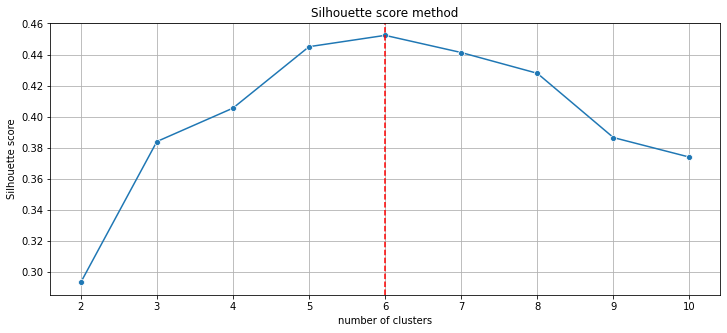

In [27]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(6, ls="--", c="red")
plt.grid()
plt.show()

In [28]:
# 클러스터 개수가 5개인 경우  
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


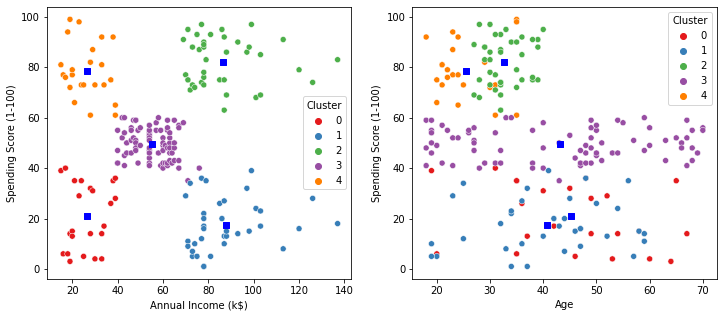

In [29]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

In [30]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,23
1,36
2,39
3,79
4,23


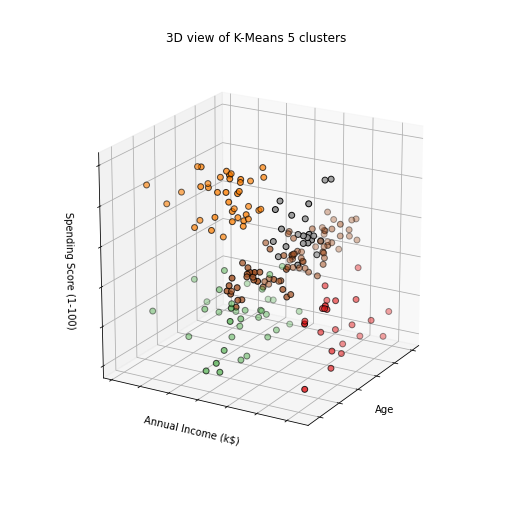

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM5_clustered['Age'],
           KM5_clustered['Annual Income (k$)'],
           KM5_clustered['Spending Score (1-100)'],
           c=KM5_clustered['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

In [32]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [33]:
# 클러스터 개수가 6개인 경우
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ # append labels to points 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



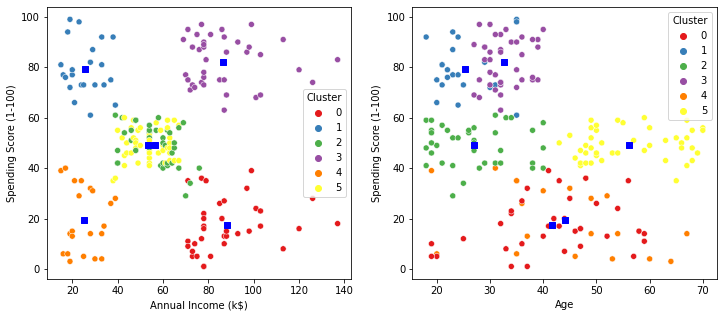

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



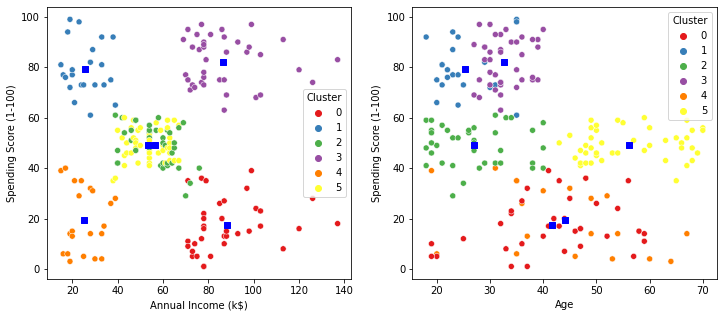

In [36]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

In [35]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ["KM_size"]
KM6_clust_sizes

,KM_size
Cluster,
0,35
1,22
2,38
3,39
4,21
5,45


In [37]:
# Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### 4.2 DBSCAN

In [38]:
from sklearn.cluster import DBSCAN

In [39]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))

In [40]:
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

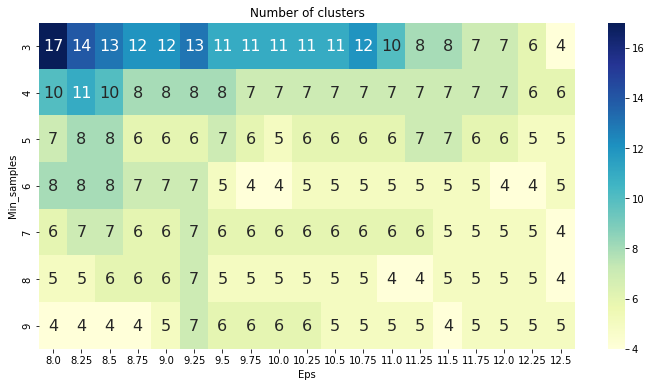

In [41]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

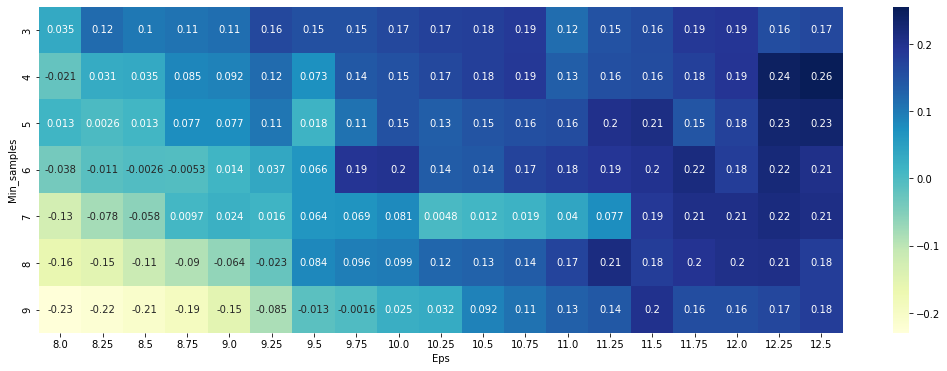

In [42]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

In [43]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [44]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



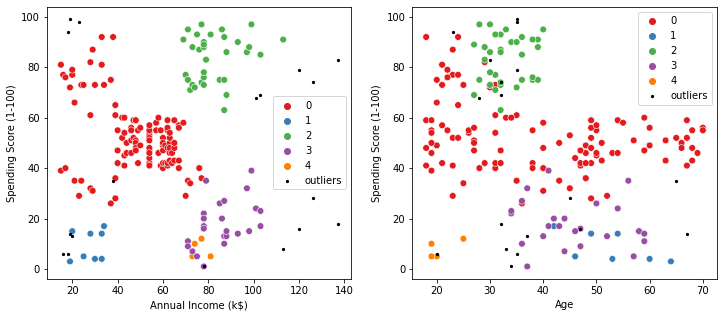

In [45]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('Age', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

### 4.3 Affinity Propagation

In [46]:
from sklearn.cluster import AffinityPropagation

In [50]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [51]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [52]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



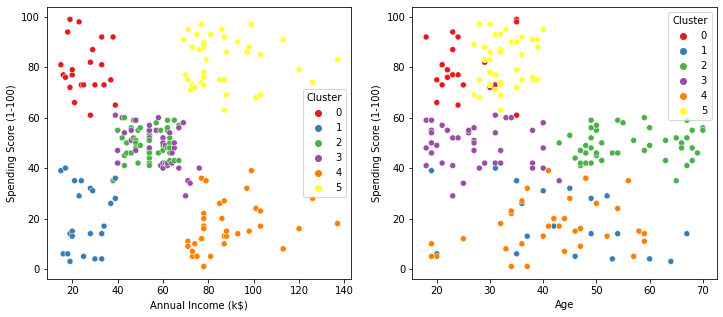

In [53]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

## 5. Comparison and discussion

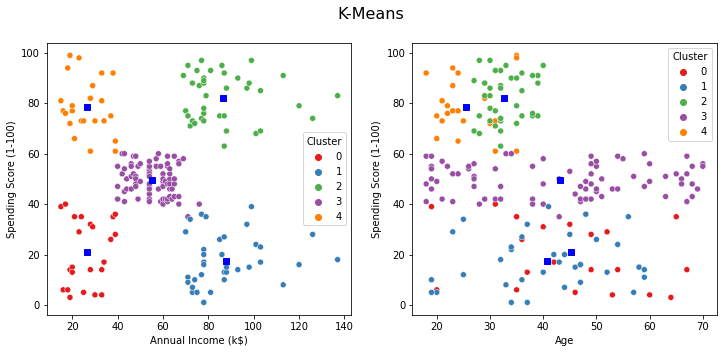

In [54]:
fig1.suptitle('K-Means', fontsize=16)
fig1

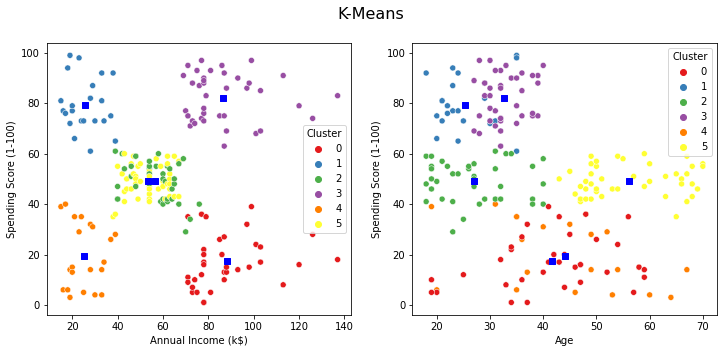

In [55]:
fig11.suptitle('K-Means', fontsize=16)
fig11

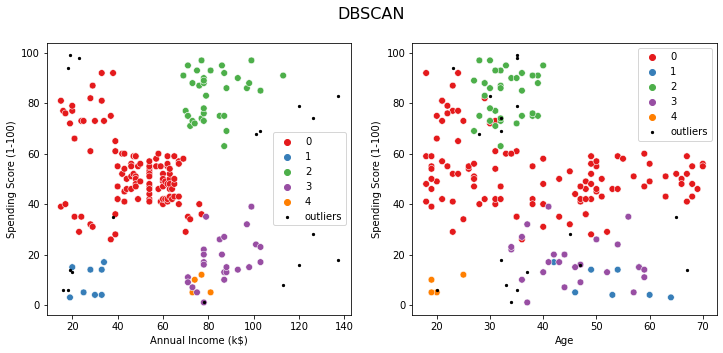

In [56]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

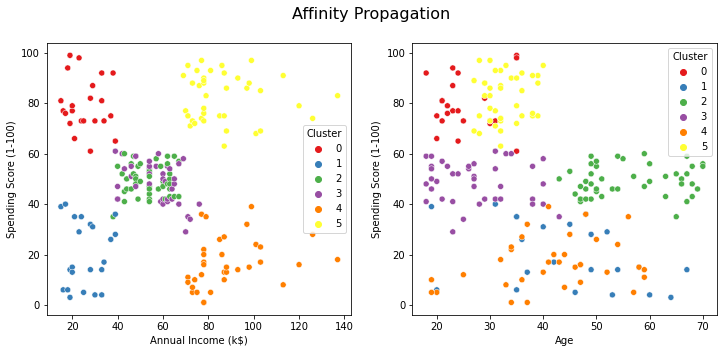

In [57]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

In [58]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
-1,NaN,18.0,NaN
0,35.0,112.0,22.0
1,22.0,8.0,22.0
2,38.0,34.0,44.0
3,39.0,24.0,39.0
4,21.0,4.0,34.0
5,45.0,NaN,39.0


From the above comparisons, it is clear that DBSCAN failed to generate reasonable clusters. It is due to its problems in recognising clusters of various densities (which are present in this case).

In turn, K-Means and Affinity Propagation algorithms created reasonable 6 clusters.